In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, explained_variance_score, max_error, d2_absolute_error_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from surprise import SVD, Reader, Dataset
from collections import defaultdict
import gzip
from surprise import SVDpp

### TRAIN DATASET

In [2]:
df_train = pd.read_csv('interactions_train.csv')

In [3]:
df_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


<Axes: xlabel='rating', ylabel='Count'>

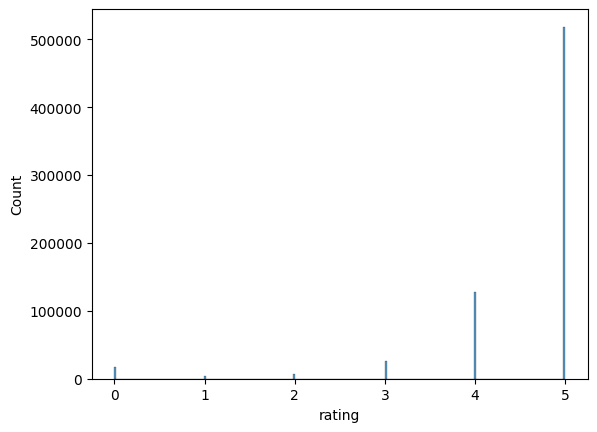

In [4]:
sns.histplot(data=df_train['rating'])

### TEST DATASET

In [5]:
df_test = pd.read_csv('interactions_test.csv')

### CODE

In [6]:
df_train = df_train[['user_id', 'recipe_id', 'rating']]
df_train.head()

,user_id,recipe_id,rating
0,2046,4684,5.0
1,2046,517,5.0
2,1773,7435,5.0
3,1773,278,4.0
4,2046,3431,5.0


In [7]:
df_test = df_test[['user_id', 'recipe_id', 'rating']]
df_test.head()

,user_id,recipe_id,rating
0,8937,44551,4.0
1,56680,126118,4.0
2,349752,219596,0.0
3,628951,82783,2.0
4,92816,435013,3.0


In [8]:
df_balanced = pd.concat([
    df_train[df_train['rating'] == 5.0].sample(n=25000, random_state=42),  # Sample 50k 5.0 ratings
    df_train[df_train['rating'] == 4.0].sample(n=25000, random_state=42),  
    df_train[(df_train['rating'] != 5.0) & (df_train['rating'] != 4.0)]  # Include all other ratings
])

In [9]:
df_balanced

,user_id,recipe_id,rating
627283,47892,327077,5.0
679919,80353,458060,5.0
100674,21399,117270,5.0
666889,28636,376310,5.0
598777,226863,344776,5.0
...,...,...,...
698857,218535,322598,1.0
698872,198154,67930,3.0
698889,2001513060,367414,1.0
698893,527509,78552,2.0


In [10]:
df_test

,user_id,recipe_id,rating
0,8937,44551,4.0
1,56680,126118,4.0
2,349752,219596,0.0
3,628951,82783,2.0
4,92816,435013,3.0
...,...,...,...
12450,101053,179011,5.0
12451,252205,81398,2.0
12452,624305,142984,1.0
12453,173575,104842,3.0


In [13]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(df_balanced[['user_id', 'recipe_id', 'rating']], reader=reader)

trainset = data.build_full_trainset()

model = SVD()

model.fit(trainset)

In [15]:
testset = Dataset.load_from_df(df_test[['user_id', 'recipe_id', 'rating']], reader=reader)

In [18]:
testset = df_test.to_dict('records')

In [21]:
for i in testset:
    print(i)

{'user_id': 8937, 'recipe_id': 44551, 'rating': 4.0}
{'user_id': 56680, 'recipe_id': 126118, 'rating': 4.0}
{'user_id': 349752, 'recipe_id': 219596, 'rating': 0.0}
{'user_id': 628951, 'recipe_id': 82783, 'rating': 2.0}
{'user_id': 92816, 'recipe_id': 435013, 'rating': 3.0}
{'user_id': 280271, 'recipe_id': 228179, 'rating': 5.0}
{'user_id': 345569, 'recipe_id': 186470, 'rating': 0.0}
{'user_id': 724516, 'recipe_id': 298748, 'rating': 5.0}
{'user_id': 176615, 'recipe_id': 118119, 'rating': 0.0}
{'user_id': 56112, 'recipe_id': 166712, 'rating': 5.0}
{'user_id': 537179, 'recipe_id': 78641, 'rating': 4.0}
{'user_id': 222478, 'recipe_id': 437144, 'rating': 5.0}
{'user_id': 22898, 'recipe_id': 65976, 'rating': 5.0}
{'user_id': 857489, 'recipe_id': 311630, 'rating': 5.0}
{'user_id': 1056692, 'recipe_id': 312579, 'rating': 4.0}
{'user_id': 89831, 'recipe_id': 74778, 'rating': 5.0}
{'user_id': 107583, 'recipe_id': 141156, 'rating': 5.0}
{'user_id': 461834, 'recipe_id': 479953, 'rating': 5.0}
{'u

In [22]:
preds = []
y_true = []
for i in testset:
    prediction = model.predict(uid=i['user_id'], iid=i['recipe_id'], verbose=False)
    preds.append(prediction.est)
    y_true.append(i['rating'])

In [27]:
preds

[3.1505511820442145,
 3.914034479915397,
 3.1029330328083864,
 3.1029330328083864,
 2.970858087496608,
 3.530012685976383,
 2.965001494949896,
 4.285146609075937,
 3.5029643520906117,
 4.098169481731866,
 3.8552864220973255,
 4.2338762324650485,
 3.252140115820729,
 2.5197124051357647,
 3.3463034332467063,
 4.437400045120479,
 3.844402307123555,
 3.6853327780528082,
 3.468452274203442,
 3.3661464902411673,
 3.0890114031202778,
 3.1460783561209666,
 3.357376931731426,
 3.1818578885994966,
 4.5337079754027885,
 3.259457318494919,
 3.1029330328083864,
 3.8886772366319513,
 3.8528479013312036,
 3.290718629666126,
 3.1029330328083864,
 4.274262592788363,
 3.7067243508972134,
 2.6931383772296256,
 2.7251857185985524,
 3.336711619913606,
 3.2541288952511533,
 3.2653591785631835,
 2.8940585730928055,
 4.148695643745768,
 3.634642771671042,
 3.833474119098262,
 3.708301866404722,
 3.1029330328083864,
 3.2053208141229814,
 3.696886528546333,
 3.1029330328083864,
 1.5948128436309361,
 3.659536911

In [28]:
y_true

[4.0,
 4.0,
 0.0,
 2.0,
 3.0,
 5.0,
 0.0,
 5.0,
 0.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 4.0,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 2.0,
 4.0,
 4.0,
 3.0,
 4.0,
 0.0,
 4.0,
 5.0,
 2.0,
 4.0,
 0.0,
 5.0,
 4.0,
 5.0,
 4.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 0.0,
 4.0,
 5.0,
 2.0,
 2.0,
 4.0,
 5.0,
 5.0,
 4.0,
 4.0,
 2.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 4.0,
 3.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 4.0,
 3.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 0.0,
 3.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 3.0,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 4.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0

In [26]:
mse = mean_squared_error(y_pred=preds, y_true=y_true)
rmse = root_mean_squared_error(y_pred=preds, y_true=y_true)
r2 = r2_score(y_pred=preds, y_true=y_true)
mse, rmse, r2

(3.0428105931849254, 1.744365384082396, -0.6985215609284412)